In [1]:
#解压数据集
!unzip data/data152113/signs.zip

Archive:  data/data152113/signs.zip
   creating: signs/
  inflating: signs/test.txt          
   creating: signs/test/
   creating: signs/test/dog/
  inflating: signs/test/dog/00000004.jpg  
  inflating: signs/test/dog/00000010.jpg  
  inflating: signs/test/dog/00000011.jpg  
  inflating: signs/test/dog/00000038.jpg  
  inflating: signs/test/dog/00000039.jpg  
  inflating: signs/test/dog/00000144.jpeg  
  inflating: signs/test/dog/00000164.jpg  
  inflating: signs/test/dog/00000165.jpg  
  inflating: signs/test/dog/00000167.jpg  
  inflating: signs/test/dog/00000170.jpg  
  inflating: signs/test/dog/00000173.jpg  
  inflating: signs/test/dog/00000206.jpg  
  inflating: signs/test/dog/00000207.jpg  
  inflating: signs/test/dog/00000212.jpg  
  inflating: signs/test/dog/00000213.jpg  
  inflating: signs/test/dog/00000359.jpg  
  inflating: signs/test/dog/00000365.jpg  
  inflating: signs/test/dog/00000366.jpg  
  inflating: signs/test/dog/00000371.jpg  
  inflating: signs/test/dog/000003

In [2]:
#导入库
import io
import os
import paddle
from PIL import Image
import paddle.io as pio
import paddle.vision.transforms as pt
import paddle.nn as nn
import numpy as np
import matplotlib.pyplot as plt

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/__init__.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/rcsetup.py:20: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable, Mapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/colors.py:53: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sized


# 导入库后，第一次运行需要标签标注，标注完成后，不再需要运行此代码块

In [3]:
#标签列表
LABEL_MAP=["ratt","ox","tiger","rabbit","dragon","snake","horse","goat","monkey","rooster","dog","pig"]
#根目录
root = 'signs'
#标注生成函数
def Annotation(mode):
    #先创建标注文件
    with open('{}/{}.txt'.format(root,mode),'w') as f:
        #训练，验证，测试三种文件夹路径
        data_dir = '{}/{}'.format(root,mode)
        #遍历文件夹,listdir函数可以返回data_dir下所有文件与文件夹列表
        for path in os.listdir(data_dir):
            #生成标签索引
            label_index = LABEL_MAP.index(path)
            #图像样本路径
            img_path = '{}/{}'.format(data_dir,path)
            #遍历所有图像样本
            for image in os.listdir(img_path):
                #单个图像的样本路径
                image_file = '{}/{}'.format(img_path,image)
                try:
                    with open(image_file,'rb') as f_img:
                        # io.BytesIO将字节对象转为Byte字节流数据,供Image.open使用
                        #f_img.read([size]) 将文件数据作为字符串返回，可选参数size控制读取的字节数
                        image=Image.open(io.BytesIO(f_img.read()))
                        #调用load()方法将强行加载图像数据
                        image.load()
                        if image.mode=='RGB':
                            #写入创建好的text文件
                            f.write('{}\t{}\n'.format(image_file,label_index))
                except:
                    continue
#生成三个数据集标注文件
Annotation(mode = 'train')
print('train annotation file created')
Annotation(mode = 'valid')
print('valid annotation file created')
Annotation(mode = 'test')
print('test annotation file created')

train annotation file created
valid annotation file created
test annotation file created


# 自定义数据集

In [4]:
#自定义数据集
class MyDataset(pio.Dataset):
    def __init__(self, mode = 'train'):
        super(MyDataset, self).__init__()
        #判断mode参数
        assert mode in ['train', 'test', 'valid'],'mode is one of train, test, valid'
        self.data = []
        #读取对应mode的索引记录
        with open('signs/{}.txt'.format(mode)) as f:
            #按行读取
            for line in f.readlines():
                #去除首尾制表符
                info = line.strip().split('\t')
                if len(info) > 0:
                    #将读取信息添加到data列表中
                    self.data.append([info[0].strip(),info[1].strip()])
        #定义预处理方法，增加样本多样性
        if mode == 'train':
            self.transforms = pt.Compose([
                pt.RandomResizedCrop(size = 224),#随机裁剪大小，从原图裁剪为224*224
                pt.RandomHorizontalFlip(0.5),#以0.5的概率随机水平翻转
                pt.ToTensor(), #转变为张量模式
                pt.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]) #归一化
            ])
        else:
            #评估不需要增加样本多样性
            self.transforms=pt.Compose([
                pt.Resize(size=256),#先压缩到256*256
                pt.RandomCrop(size=224),
                pt.ToTensor(),
                pt.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])#归一化
            ])
    def __getitem__(self,index):
        #获取单个样本数据和标签
        image_file,label = self.data[index]
        image = Image.open(image_file)
        #非RGB格式图像转化为RGB格式
        if image.mode != 'RGB':
            image = image.convert('RGB')
        #图像预处理
        image = self.transforms(image)
        #将标签转换为numpy形式
        return image,np.array(label, dtype = 'int64')
    def __len__(self):
        return (len(self.data))

# 创建数据集实例


In [5]:
#创建数据集实例
train_data = MyDataset(mode = 'train')
test_data = MyDataset(mode = 'test')
valid_data = MyDataset(mode = 'valid')
print ('训练集数目: {}, 验证集数目: {}, 测试集数目: {}'.format(len(train_data),len(valid_data),len(test_data)))

训练集数目: 7096, 验证集数目: 639, 测试集数目: 601


# VGG16网络组网

In [6]:
#模型组网VGG-16
class VGG(nn.Layer):
    def __init__(self):
        super(VGG,self).__init__()
        self.act = nn.ReLU()
        #第一部分
        self.c1_1=nn.Conv2D(3,64,3,1,1)
        self.c1_2=nn.Conv2D(64,64,3,1,1)
        self.m1=nn.MaxPool2D(kernel_size=2,stride=2)
        #第二部分
        self.c2_1=nn.Conv2D(64,128,3,1,1)
        self.c2_2=nn.Conv2D(128,128,3,1,1)
        self.m2=nn.MaxPool2D(kernel_size=2,stride=2)
        #第三部分
        self.c3_1=nn.Conv2D(128,256,3,1,1)
        self.c3_2=nn.Conv2D(256,256,3,1,1)
        self.c3_3=nn.Conv2D(256,256,3,1,1)
        self.m3=nn.MaxPool2D(kernel_size=2,stride=2)
        #第四部分
        self.c4_1=nn.Conv2D(256,512,3,1,1)
        self.c4_2=nn.Conv2D(512,512,3,1,1)
        self.c4_3=nn.Conv2D(512,512,3,1,1)
        self.m4=nn.MaxPool2D(kernel_size=2,stride=2)
        #第五部分
        self.c5_1=nn.Conv2D(512,512,3,1,1)
        self.c5_2=nn.Conv2D(512,512,3,1,1)
        self.c5_3=nn.Conv2D(512,512,3,1,1)
        self.m5=nn.MaxPool2D(kernel_size=2,stride=2)
        self.fl=nn.Flatten()
        self.fc1=nn.Linear(in_features=512*7*7,out_features=4096)
        self.fc2=nn.Linear(in_features=4096,out_features=4096)
        self.fc3=nn.Linear(in_features=4096,out_features=12)
        self.d=nn.Dropout()
    
    def forward(self,inputs):
        x=self.c1_1(inputs)
        x=self.act(x)
        x=self.c1_2(x)
        x=self.act(x)
        x=self.m1(x)
       
        x=self.c2_1(x)
        x=self.act(x)
        x=self.c2_2(x)
        x=self.act(x)
        x=self.m2(x)

        x=self.c3_1(x)
        x=self.act(x)
        x=self.c3_2(x)
        x=self.act(x)
        x=self.c3_3(x)
        x=self.act(x)
        x=self.m3(x)

        x=self.c4_1(x)
        x=self.act(x)
        x=self.c4_2(x)
        x=self.act(x)
        x=self.c4_3(x)
        x=self.act(x)
        x=self.m4(x)

        x=self.c5_1(x)
        x=self.act(x)
        x=self.c5_2(x)
        x=self.act(x)
        x=self.c5_3(x)
        x=self.act(x)
        x=self.m5(x)

        #接分类层
        x=self.fl(x)

        x=self.fc1(x)
        x=self.act(x)
        x=self.d(x)

        x=self.fc2(x)
        x=self.act(x)
        x=self.d(x)

        x=self.fc3(x)
        return x
model = VGG()
paddle.summary(model,(1,3,224,224))

W0613 21:59:31.188160   166 gpu_context.cc:278] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 11.2, Runtime API Version: 10.1
W0613 21:59:31.191511   166 gpu_context.cc:306] device: 0, cuDNN Version: 7.6.


---------------------------------------------------------------------------
 Layer (type)       Input Shape          Output Shape         Param #    
   Conv2D-1      [[1, 3, 224, 224]]   [1, 64, 224, 224]        1,792     
    ReLU-1          [[1, 4096]]           [1, 4096]              0       
   Conv2D-2     [[1, 64, 224, 224]]   [1, 64, 224, 224]       36,928     
  MaxPool2D-1   [[1, 64, 224, 224]]   [1, 64, 112, 112]          0       
   Conv2D-3     [[1, 64, 112, 112]]   [1, 128, 112, 112]      73,856     
   Conv2D-4     [[1, 128, 112, 112]]  [1, 128, 112, 112]      147,584    
  MaxPool2D-2   [[1, 128, 112, 112]]   [1, 128, 56, 56]          0       
   Conv2D-5      [[1, 128, 56, 56]]    [1, 256, 56, 56]       295,168    
   Conv2D-6      [[1, 256, 56, 56]]    [1, 256, 56, 56]       590,080    
   Conv2D-7      [[1, 256, 56, 56]]    [1, 256, 56, 56]       590,080    
  MaxPool2D-3    [[1, 256, 56, 56]]    [1, 256, 28, 28]          0       
   Conv2D-8      [[1, 256, 28, 28]] 

{'total_params': 134309708, 'trainable_params': 134309708}

# 开始训练，首先调整参数

In [ ]:
#超参设置
batch_size = 256
epochs = 20
learning_rate = 0.0001
#损失函数:cross_entropy为交叉熵损失，nll为negative log likelihood loss损失
loss_function = 'nll'

#开始训练
train_d = paddle.io.DataLoader(train_data, batch_size=batch_size,shuffle=True,drop_last=True)
valid_d = paddle.io.DataLoader(valid_data, batch_size=batch_size,shuffle=True,drop_last=True)
def train(model,epochs,learning_rate,loss_function,batch_size):
    use_gpu = True
    #资源配置
    paddle.set_device('gpu:0') if use_gpu else paddle.set_device('cpu')

    cross_entropy = paddle.nn.CrossEntropyLoss()
    log_softmax = paddle.nn.LogSoftmax(axis = 1)
    nll = paddle.nn.NLLLoss()

    #用正则化来提升精度
    #opt = paddle.optimizer.Adam(learning_rate=learning_rate,parameters=model.parameters())
    opt = paddle.optimizer.Momentum(learning_rate=learning_rate,parameters=model.parameters(),weight_decay=0.0001)
    iter1 = 0
    iters = []
    losses = []
    acces = []
    model.train()
    #进行数据记录
    for epoch in range(epochs):
        for batch_id,data in enumerate(train_d()):
            image = data[0]
            label = data[1]
            label = paddle.reshape(label,(batch_size,1))
            label_1 = label
            predict = model (image)
            if loss_function == 'cross_entropy':
                loss = cross_entropy(predict,label)
            elif loss_function == 'nll':
                #predict = paddle.reshape(predict,(batch_size,1))
                #predict = paddle.cast(predict,dtype='float32')
                label = paddle.cast(label,dtype='int64')
                predict = log_softmax(predict)
                loss = nll(predict,label)
            else:
                print('wrong loss function')
                exit
            avg_loss=paddle.mean(loss)
            predict_1=nn.functional.softmax(predict)
            acc=paddle.metric.accuracy(predict_1,label_1)
            
            if batch_id % 10 ==0:
                print('epoch_id:{}, batch_id:{}, train_loss:{}, train_acc:{}'.format(epoch,batch_id,avg_loss.numpy(),acc.numpy()))
                iters.append(iter1)
                acces.append(acc.numpy())
                losses.append(avg_loss.numpy())
                iter1 = iter1 + 10
            avg_loss.backward()
            opt.step()
            opt.clear_grad()
        model.eval()
        total_acc = []
        total_loss = []
        #验证数据
        for batch_id,data in enumerate(valid_d()):
            v_image=data[0]
            v_label=data[1]
            v_label=paddle.reshape(v_label,(batch_size,1))
            v_label_1 = v_label
            v_predict=model(v_image)
            if loss_function == 'cross_entropy':
                v_loss = nn.functional.cross_entropy(v_predict,v_label)
            elif loss_function == 'nll':
                #v_predict = paddle.reshape(predict,(batch_size,1))
                #v_predict = paddle.cast(predict,dtype='float32')
                v_label = paddle.cast(v_label,dtype='int64')
                v_predict = log_softmax(v_predict)
                v_loss = nll(v_predict,v_label)
            else:
                print('wrong loss function')
                exit
            v_avg_loss=paddle.mean(v_loss)
            v_predict_1=nn.functional.softmax(v_predict)
            v_acc=paddle.metric.accuracy(v_predict_1,v_label_1)
            v_avg_loss.backward()
            opt.step()
            opt.clear_grad()
            total_loss.append(v_avg_loss.numpy())
            total_acc.append(v_acc.numpy())
        mean_loss=np.mean(total_loss)
        mean_acc=np.mean(total_acc)
        print('epoch_id:{},  valid_loss:{},  valid_acc:{}  '.format(epoch,mean_loss,mean_acc))
        model.train()
    return iters, losses, acces
model = VGG（）
#恢复训练
#params_file_path = './REPVGG_AC.pdparams'
#param_dict = paddle.load(params_file_path)
#model.load_dict(param_dict)
iters,losses,acces=train(model,epochs,learning_rate,loss_function,batch_size)
paddle.save(model.state_dict(),'./REPVGG_MN.pdparams')


epoch_id:0, batch_id:0, train_loss:[0.47962227], train_acc:[0.1015625]
epoch_id:0, batch_id:10, train_loss:[0.82007015], train_acc:[0.0625]
epoch_id:0, batch_id:20, train_loss:[0.8713926], train_acc:[0.109375]
epoch_id:0, batch_id:30, train_loss:[0.8407769], train_acc:[0.078125]
epoch_id:0, batch_id:40, train_loss:[0.8462202], train_acc:[0.0703125]
epoch_id:0, batch_id:50, train_loss:[0.8414019], train_acc:[0.0859375]


# 测试训练模型

In [4]:
#模型评估测试
test_d=paddle.io.DataLoader(test_data,batch_size=32,shuffle=True,drop_last=True)
def evalution(model):
    print("evalution start......")
    #读取模型文件
    params_file_path = './0608_1.pdparams'
    param_dict = paddle.load(params_file_path)
    model.load_dict(param_dict)
    model.eval()
    e_total_acc=[]
    e_total_loss=[]
    tp=0
    fn=0
    fp=0
    tn=0
    for batch_id,data in enumerate(test_d()):
        img = data[0]
        label=data[1]
        label=paddle.reshape(label,(32,1))
        predict=model(img)
        #loss值获取
        loss=nn.functional.cross_entropy(predict,label)
        avg_loss=paddle.mean(loss)

        #accuracy获取
        predict_1=nn.functional.softmax(predict)
        predict_2=nn.functional.sigmoid(predict)
        acc=paddle.metric.accuracy(predict_1,label)
        e_total_acc.append(acc.numpy())
        e_total_loss.append(avg_loss.numpy())
        print(predict)
        print(predict_1)
        print(label)
        return

        print(type(predict))
        print(type(predict_1))

        #precision获取
        #recall获取
    acc=np.mean(e_total_acc)
    loss=np.mean(e_total_loss)
    prec=
    recall=
    print('test_loss:{}, test_acc:{}, test_error:{}, test_precision:{}, test_recall:{}'.format(loss,acc,1-acc,prec,recall))
model=VGG()
evalution(model)


evalution start......
Tensor(shape=[32, 12], dtype=float32, place=Place(gpu:0), stop_gradient=False,
       [[-2.40907645 ,  3.37380648 , -3.26359630 , -2.95006013 ,  1.91786134 ,
         -2.50426245 ,  4.82265139 ,  2.00100946 , -3.06227899 ,  3.32317710 ,
          1.00109458 , -3.48613787 ],
        [-4.80072594 ,  9.01554298 , -2.19774079 , -2.40995812 , -5.47204971 ,
         -6.41425610 ,  2.54445291 ,  10.19836330, -0.12604778 , -2.48529100 ,
          2.26609850 ,  0.18553492 ],
        [ 23.11033249, -3.41590786 , -9.60511684 ,  5.23354673 , -0.56093168 ,
         -4.42958450 , -4.48463917 , -3.86223602 , -2.56281590 , -4.61674356 ,
         -2.47049546 ,  5.85145760 ],
        [-1.77635396 ,  0.32984596 ,  1.05050313 ,  0.49846110 , -1.35029137 ,
          0.82978499 ,  0.22365177 ,  0.47979578 , -0.43571502 , -0.01840392 ,
         -0.32702869 ,  0.17696646 ],
        [ 0.90796494 ,  1.19482374 , -1.82967329 , -0.62090015 ,  0.98908603 ,
         -3.27333355 ,  0.74510103 ,

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/colors.py:101: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  ret = np.asscalar(ex)


f1_score: 0.8344970888312148
accuracy: 0.8350694444444444
error rate: 0.16493055555555558
precision: 0.8352476812856454
recall: 0.8352225338784375


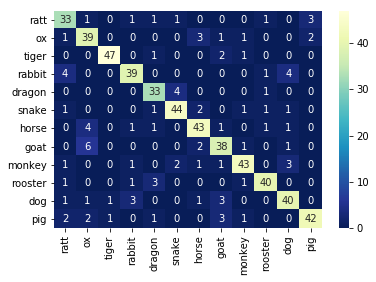

In [7]:
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,f1_score,classification_report
import pandas as pd
import seaborn as sns

params_file_path = './VGG16_0613.pdparams'
param_dict = paddle.load(params_file_path)
model.load_dict(param_dict)
test_d=paddle.io.DataLoader(test_data,batch_size=32,shuffle=True,drop_last=True)
y_p = []
y_t = []
for batch, (test_X,test_y) in enumerate(test_d):
    y_pred = model(test_X)
    for i in y_pred:
        y_p.append(np.argmax(i))
    #y_p.append(y_pred)
    for i in test_y:
        y_t.append(int(i))

cm = confusion_matrix(y_t,y_p)
cm = pd.DataFrame(cm,columns=["ratt","ox","tiger","rabbit","dragon","snake","horse","goat","monkey","rooster","dog","pig"],index=["ratt","ox","tiger","rabbit","dragon","snake","horse","goat","monkey","rooster","dog","pig"])
sns.heatmap(cm,cmap="YlGnBu_r",fmt="d",annot=True)

print('f1_score:',f1_score(y_t,y_p,average='macro'))
print('accuracy:',accuracy_score(y_t,y_p))
print('error rate:',1-accuracy_score(y_t,y_p))
print('precision:',precision_score(y_t,y_p,average='macro'))
print('recall:',recall_score(y_t,y_p,average='macro'))

# 模型预测

['test/1655093332953.jpg', 'test/1655093633531.jpg', 'test/1655093686191.jpg', 'test/1655093470765.jpg', 'test/1655093657112.jpg', 'test/1655093453707.jpg', 'test/1655093591239.jpg', 'test/1655093499390.jpg', 'test/1655093372043.jpg', 'test/1655093403889.jpg', 'test/1655093427122.jpg', 'test/1655093528534.jpg']


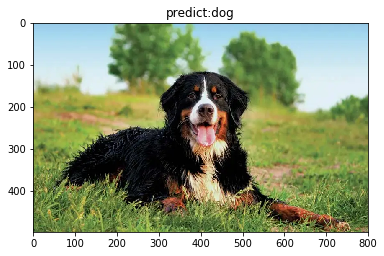

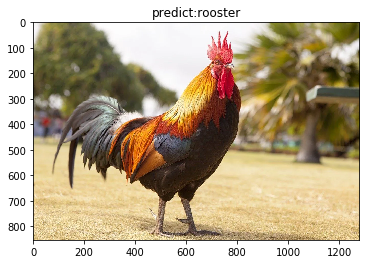

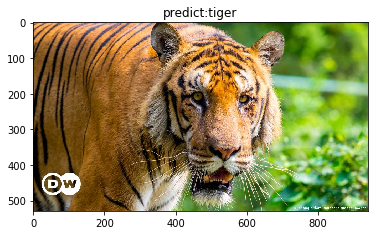

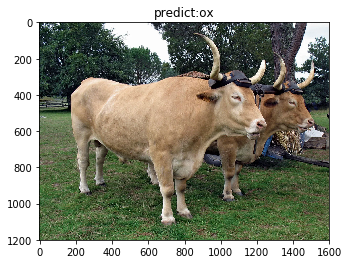

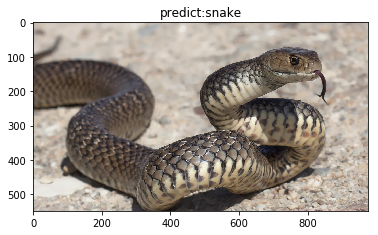

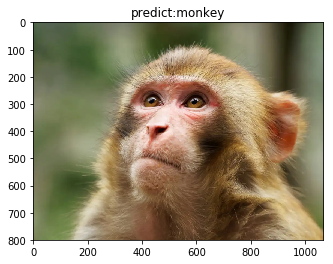

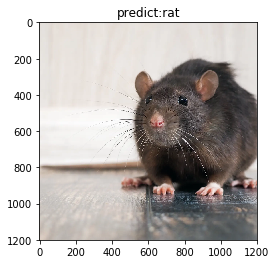

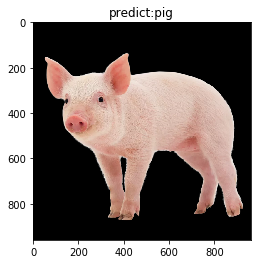

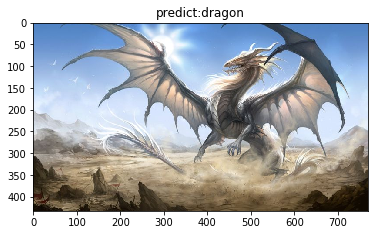

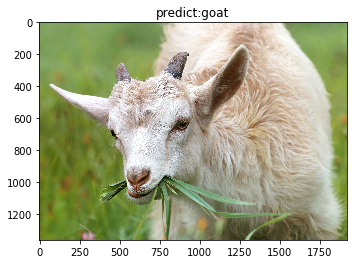

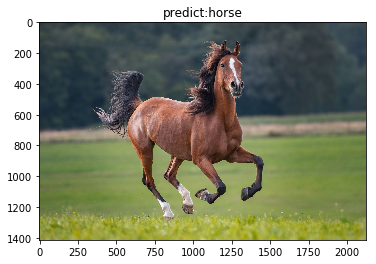

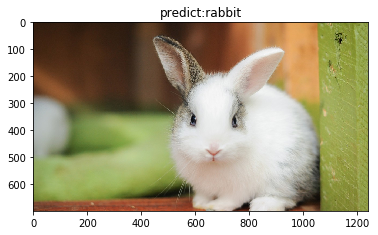

In [8]:
LABEL_MAP=["rat","ox","tiger","rabbit","dragon","snake","horse","goat","monkey","rooster","dog","pig"]
#test2文件夹进行测试模型
root1='test'
#将图片路径写入txt文本文件
with open('{}.txt'.format(root1),'w') as f:
    for image in os.listdir(root1):
        #单个图像样本路径
        image_file1='{}/{}'.format(root1,image)
        f.write('{}\n'.format(image_file1))
#定义预处理方式
def transform(img):
    if img.mode !='RGB':
        img=img.convert('RGB')
    transforms=pt.Compose([
                pt.Resize(size=256),#先压缩到256*256
                pt.RandomCrop(size=224),
                pt.ToTensor(),
                pt.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])#归一化
            ])
    img=transforms(img)
    img=paddle.reshape(img,(1,3,224,224))
    return img

#将创建好的文本中图片路径写入一个列表
test_list=[]
with open('test.txt') as f:
    img=f.readlines()
    for i in range(len(img)):
        test_list.append(img[i].strip())
    print(test_list)
#加载模型
model=VGG()
params_file_path = './VGG16_0613.pdparams'
param_dict = paddle.load(params_file_path)
model.load_dict(param_dict)
model.eval()
for i in range(12):
    img=Image.open(test_list[i])
    plt.figure()
    plt.imshow(img)
    img=transform(img)
    result=model(img)
    result=paddle.argmax(result[0])
    plt.title('predict:{}'.format(LABEL_MAP[result]))
    plt.axis('on')
    plt.show()